In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.distributions.kl import kl_divergence
from torch.distributions import Normal

In $K$-shot sinusoid regression,  meta learners aim at quickly adapting the model to an unseen function $f(x)=a\sin(x+b)$ with the help of $K$ data points randomly sampled from the function.
This case treats the amplitude and phase variables $(a,b)$ as the task identifier to configure the task.

In [104]:
#generating sinusoidal data
class SineTask():
    def __init__(self,amp,phase,min_x,max_x):
        self.phase=phase
        self.max_x=max_x
        self.min_x=min_x
        self.amp=amp

    def sample_data(self,size=1):
        x=np.random.uniform(self.max_x,self.min_x,size)
        y=self.true_sine(x)
        x=torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y=torch.tensor(y, dtype=torch.float).unsqueeze(1)
        return x,y

    def true_sine(self,x):
        y=self.amp*np.sin(self.phase+x)
        return y

In [105]:
class SineDistribution():
    def __init__(self, min_amp, max_amp, min_phase, max_phase, min_x, max_x):
        self.min_amp = min_amp
        self.max_phase = max_phase
        self.min_phase = min_phase
        self.max_amp = max_amp
        self.min_x = min_x
        self.max_x = max_x

    def sample_task(self):
        amp = np.random.uniform(self.min_amp, self.max_amp)
        phase = np.random.uniform(self.min_phase, self.max_phase)
        return SineTask(amp, phase, self.min_x, self.max_x)

    def active_sample_task(self, amp, phase):
        return SineTask(amp, phase, self.min_x, self.max_x)

    def task_descriptor_candidate(self, num_candidate):
        # grid search get 100 candidate tasks.
        amp_list_candidate = np.random.uniform(self.min_amp, self.max_amp, size=[num_candidate, 1])
        phase_list_candidate = np.random.uniform(self.min_phase, self.max_phase, size=[num_candidate, 1])
        amp_list_candidate = np.float32(amp_list_candidate)
        phase_list_candidate = np.float32(phase_list_candidate)
        return amp_list_candidate, phase_list_candidate

**Meta Learner**

Sine-net is the model's backbone with the parameter $\theta$ (meta learner).

In [106]:
# defining our sine-net
class SineNet(nn.Module):
    def __init__(self):
        super(SineNet, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(1, 40)),
            ('relu1', nn.ReLU()),
            ('l2', nn.Linear(40, 40)),
            ('relu2', nn.ReLU()),
            ('l3', nn.Linear(40, 1))
        ]))

    # We implemented argforward() so that we could use a set of custom weights for evaluation.
    # This is important for the "inner loop" in MAML where you temporarily update the weights
    # of the network for a task to calculate the meta-loss and then reset them for the next meta-task.

    def argforward(self, x, weights):
        x = F.linear(x, weights[0], weights[1])
        x = F.relu(x)
        x = F.linear(x, weights[2], weights[3])
        x = F.relu(x)
        x = F.linear(x, weights[4], weights[5])
        return x

**RiskLearner:**

We use basic architecture from
https://github.com/EmilienDupont/neural-processes

other options:
https://github.com/automl/TransformersCanDoBayesianInference


The risk learner is in an encoder-decoder structure, defined as $\phi$ and $\psi$ respectively.  


In [107]:
# Basic functions in RiskLearner
class Encoder(nn.Module):
    """Maps an (x_i, y_i) pair to a representation r_i."""

    def __init__(self, x_dim, y_dim, h_dim, r_dim):
        super(Encoder, self).__init__()

        self.x_dim = x_dim
        self.y_dim = y_dim
        self.h_dim = h_dim
        self.r_dim = r_dim

        layers = [nn.Linear(x_dim + y_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, r_dim)]

        self.input_to_hidden = nn.Sequential(*layers)

    def forward(self, x, y):
        input_pairs = torch.cat((x, y), dim=1)
        return self.input_to_hidden(input_pairs)


class MuSigmaEncoder(nn.Module):
    """Maps r to z."""

    def __init__(self, r_dim, z_dim):
        super(MuSigmaEncoder, self).__init__()

        self.r_dim = r_dim
        self.z_dim = z_dim

        self.r_to_hidden = nn.Linear(r_dim, r_dim)
        self.hidden_to_mu = nn.Linear(r_dim, z_dim)
        self.hidden_to_sigma = nn.Linear(r_dim, z_dim)

    def forward(self, r):
        hidden = torch.relu(self.r_to_hidden(r))
        mu = self.hidden_to_mu(hidden)
        sigma = 0.1 + 0.9 * torch.sigmoid(self.hidden_to_sigma(hidden))
        return mu, sigma


class Decoder(nn.Module):
    """Maps (x+z) to y."""

    def __init__(self, x_dim, z_dim, h_dim, y_dim):
        super(Decoder, self).__init__()

        self.x_dim = x_dim
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.y_dim = y_dim

        layers = [nn.Linear(x_dim + z_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True)]

        self.xz_to_hidden = nn.Sequential(*layers)
        self.hidden_to_mu = nn.Linear(h_dim, y_dim)
        self.hidden_to_sigma = nn.Linear(h_dim, y_dim)

    def forward(self, x, z, output_type):
        # batch_size=1

        batch_size, num_points, _ = x.size()
        num_repeat, _, _ = z.size()

        if batch_size == 1:
            x = x.repeat(num_repeat, 1, 1)
            z = z.repeat(1, num_points, 1)

            x_flat = x.view(num_repeat * num_points, self.x_dim)
            z_flat = z.view(num_repeat * num_points, self.z_dim)

            input_pairs = torch.cat((x_flat, z_flat), dim=1)
            hidden = self.xz_to_hidden(input_pairs)
            mu = self.hidden_to_mu(hidden)
            pre_sigma = self.hidden_to_sigma(hidden)

            mu = mu.view(num_repeat, num_points, self.y_dim)

            if output_type == "probabilistic":
                pre_sigma = pre_sigma.view(num_repeat, num_points, self.y_dim)
                sigma = 0.1 + 0.9 * F.softplus(pre_sigma)
                p_y_pred = Normal(mu, sigma)
                p_y_pred = p_y_pred.rsample([1])[0]
            else:
                p_y_pred = mu

            return p_y_pred

In [108]:
# Define RiskLearner for the current task distribution and the current backbone parameters...

class RiskLearner(nn.Module):
    """
    Implements risklearner for functions of arbitrary dimensions.
    x_dim : int Dimension of x values.
    y_dim : int Dimension of y values.
    r_dim : int Dimension of output representation r.
    z_dim : int Dimension of latent variable z.
    h_dim : int Dimension of hidden layer in encoder and decoder.
    """

    def __init__(self, x_dim, y_dim, r_dim, z_dim, h_dim):
        super(RiskLearner, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.r_dim = r_dim
        self.z_dim = z_dim
        self.h_dim = h_dim

        # Initialize networks
        self.xy_to_r = Encoder(x_dim, y_dim, h_dim, r_dim)
        self.r_to_mu_sigma = MuSigmaEncoder(r_dim, z_dim)
        self.xz_to_y = Decoder(x_dim, z_dim, h_dim, y_dim)

    def aggregate(self, r_i):
        return torch.mean(r_i, dim=1)

    def xy_to_mu_sigma(self, x, y):
        """
        Maps (x, y) pairs into the mu and sigma parameters defining the normal
        distribution of the latent variables z.
        """
        batch_size, num_points, _ = x.size()
        x_flat = x.view(batch_size * num_points, self.x_dim)
        y_flat = y.contiguous().view(batch_size * num_points, self.y_dim)
        r_i_flat = self.xy_to_r(x_flat, y_flat)
        r_i = r_i_flat.view(batch_size, num_points, self.r_dim)

        # Aggregate representations r_i into a single representation r
        r = self.aggregate(r_i)
        return self.r_to_mu_sigma(r)

    def forward(self, x, y, output_type):
        """
        returns a distribution over target points y_target. We follow the convention given in "Empirical Evaluation of Neural
        Process Objectives" where context is a subset of target points. This was
        shown to work best empirically.
        """
        if self.training:

            mu, sigma = self.xy_to_mu_sigma(x, y)
            z_variational_posterior = Normal(mu, sigma)

            z_sample = z_variational_posterior.rsample([20]) # increase the number of samples
            p_y_pred = self.xz_to_y(x, z_sample, output_type)
            return p_y_pred, z_variational_posterior
      

**RiskLearner Trainer:**

- ELBO:
$$\max_{\psi\in\Psi,\phi\in\Phi}\mathcal{G}_{\text{ELBO}}(\psi,\phi):=\mathbb{E}_{q_{\phi}(z_{t}\vert H_{t})}\left[\sum_{i=1}^{\mathcal{B}}\ln p_{\psi}(\ell_{t,i}\vert\tau_{t,i},z_{t})\right]-\beta D_{KL}\Big[q_{\phi}(z_{t}\vert H_{t})\parallel q_{\bar{\phi}}(z_{t}\vert H_{t-1})\Big]$$
where $\bar{\phi}$ indicates no gradients computed through $\phi$ in the term, and $\{\beta\in\mathbb{R}^{+},\epsilon\in\mathbb{R}^{+}\}$ constrains the machine learner's parameter search in next iteration.

- Acquisition function built on the UCB principle:
$$
        \mathcal{A}(\mathcal{T}^{\mathcal{B}};\phi,\psi)=\sum_{i=1}^{\mathcal{B}}a(\tau_i)
        =\sum_{i=1}^{\mathcal{B}}\gamma_0\overbrace{m(\ell_i)}^{\text{Risk Mean}}+\gamma_1\overbrace{\sigma(\ell_i)}^{\text{Epistemic Uncertainty}},
        \
        \text{where}
        \
        \tau_i\sim p(\tau)
        \\
        \text{with}
        \
        m(\ell_i)=\mathbb{E}_{q_{\phi}(z_{t}\vert H_{t})}\Big[p_{\psi}(\ell\vert\tau_i, z_{t})\Big]
        \
        \text{and}
        \
        \sigma(\ell_i)=\mathbb{V}_{q_{\phi}(z_{t}\vert H_{t})}^{\frac{1}{2}}\Big[p_{\psi}(\ell\vert\tau_i,z_{t})\Big],
    $$
where $m(\ell_i)$ and $\sigma(\ell_i)$ are, respectively, the adaptation risk mean and standard deviations, which can be estimated from multiple stochastic forward passes $z_t\sim p(z_t\vert H_{1:t})$ and $\ell\sim p_{\psi}(\ell\vert\tau_{i},z_t)$ using the risk generative model.
And $\{\gamma_0,\gamma_1\}$ are hyperparameters to balance considerations.


In [109]:
class RiskLearnerTrainer():
    """
    Class to handle training of RiskLearner for functions.
    """

    def __init__(self, device, risklearner, optimizer):

        self.device = device
        self.risklearner = risklearner
        self.optimizer = optimizer

        # ++++++Prediction distribution p(l|tau)++++++++++++++++++++++++++++
        self.output_type = "deterministic"

        # ++++++initialize the p(z_0)++++++++++++++++++++++++++++
        r_dim = self.risklearner.r_dim
        prior_init_mu = torch.zeros([1, r_dim]).to(self.device)
        prior_init_sigma = torch.ones([1, r_dim]).to(self.device)
        self.z_prior = Normal(prior_init_mu, prior_init_sigma)
        self.last_risk_x = None
        self.last_risk_y = None

        # ++++++Acquisition functions++++++++++++++++++++++++++++
        self.num_samples = 20

    def train(self, Risk_X, Risk_Y):
        Risk_X, Risk_Y = Risk_X.unsqueeze(0), Risk_Y.unsqueeze(0).unsqueeze(-1)
        # shape: batch_size, num_points, dim

        self.optimizer.zero_grad()
        p_y_pred, z_variational_posterior = self.risklearner(Risk_X, Risk_Y, self.output_type)
        z_prior = self.z_prior

        loss = self._loss(p_y_pred, Risk_Y, z_variational_posterior, z_prior)
        loss.backward()
        self.optimizer.step()

        # updated z_prior
        self.z_prior = Normal(z_variational_posterior.loc.detach(), z_variational_posterior.scale.detach())
        self.last_risk_x = Risk_X
        self.last_risk_y = Risk_Y

        return loss

    def negative_log_likelihood(self, y_true, mu, sigma):
        # Avoid division by zero
        sigma = torch.clamp(sigma, min=1e-6)
        # Compute the negative log likelihood
        loss = 0.5 * torch.log(sigma ** 2) + 0.5 * ((y_true - mu) ** 2) / (sigma ** 2)
        return loss.mean()  # taking mean over all samples if batched

    def _loss(self, p_y_pred, y_target, posterior, prior):

        negative_log_likelihood = F.mse_loss(p_y_pred.mean(0, keepdim=True), y_target, reduction="sum")

        # KL has shape (batch_size, r_dim). Take mean over batch and sum over r_dim (since r_dim is dimension of normal distribution)
        kl = kl_divergence(posterior, prior).mean(dim=0).sum()

        return negative_log_likelihood + kl

    def acquisition_function(self, Risk_X_candidate, gamma_mu, gamma_sigma):

        Risk_X_candidate = Risk_X_candidate.to(self.device)
        x = Risk_X_candidate.unsqueeze(0)
        
        if self.last_risk_x is None:
            z_sample = self.z_prior.rsample([self.num_samples])
        else:
            _, z_variational_posterior = self.risklearner(self.last_risk_x, self.last_risk_y, self.output_type)
            z_posterior = Normal(z_variational_posterior.loc.detach(), z_variational_posterior.scale.detach())
            z_sample = z_posterior.rsample([self.num_samples])   # sampling from prior
        # Shape: num_samples * 1 * 10

        p_y_pred = self.risklearner.xz_to_y(x, z_sample, self.output_type)
        # Shape: num_samples * num_candidate * 1

        output_mu = torch.mean(p_y_pred, dim=0)
        output_sigma = torch.std(p_y_pred, dim=0)
        acquisition_score = gamma_mu * output_mu + gamma_sigma * output_sigma
        return acquisition_score, p_y_pred

In [110]:
def single_task_test(og_net, x, y, axis, task):
    test_alpha = 0.001
    test_inner_steps = 10
    criterion = nn.MSELoss()

    # modeling initialization
    dummy_net = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1, 40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40, 40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40, 1))]))
    dummy_net = dummy_net.to(device)
    dummy_net.load_state_dict(og_net.state_dict())
    optim = torch.optim.SGD
    opt = optim(dummy_net.parameters(), lr=test_alpha)

    losses = []
    outputs = {}

    # fast adaptation for #inner_steps
    for i in range(test_inner_steps):
        out = dummy_net(x)
        loss = criterion(out, y)
        losses.append(loss.item())

        dummy_net.zero_grad()
        loss.backward()
        opt.step()

    # Inference for the current task
    outputs['initial'] = og_net(axis.view(-1, 1)).clone().detach().cpu().numpy()
    outputs['adapted'] = dummy_net(axis.view(-1, 1)).clone().detach().cpu().numpy()
    outputs["gt"] = task.true_sine(axis.cpu().clone().numpy())

    meta_losses = criterion(torch.tensor(outputs["adapted"]), torch.tensor(outputs["gt"]).unsqueeze(1))

    return outputs, meta_losses

In [111]:
def test(tasks, og_net, k, global_seed):

    # +++++++++++++++++++++
    # Fixed Meta-Test Tasks
    seed = 1000000
    np.random.seed(seed)
    num_test_tasks = 1000
    # +++++++++++++++++++++
    test_MSE_all = []

    # Generating test task discriptors
    test_amp_list, test_phase_list = tasks.task_descriptor_candidate(num_test_tasks)

    # Testing
    for i in range(num_test_tasks):
        test_task = tasks.active_sample_task(test_amp_list[i], test_phase_list[i])
        # target set
        x, y = test_task.sample_data(k)
        x, y = x.to(device), y.to(device)

        # query set
        axis = np.linspace(-5, 5, 1000)
        axis = torch.tensor(axis, dtype=torch.float)
        axis = axis.to(device)

        outputs, meta_losses = single_task_test(og_net, x, y, axis, test_task)
        test_MSE_all.append(meta_losses)

    test_MSE_all = torch.Tensor(test_MSE_all)
    test_score = test_MSE_all.mean()
    np.random.seed(global_seed)
    return test_score

MAML sine backbone

https://github.com/GauravIyer/MAML-Pytorch/blob/master/Experiment%201/Experiment_1_Sine_Regression.ipynb

In [112]:
class SineMAML():
    def __init__(self, sine_tasks, net, alpha, beta, k, num_candidates, num_metatasks, sampling_strategy, num_epochs, global_seed, gamma_mu, gamma_sigma):
        self.global_seed = global_seed
        self.device = device
        # set the risklearner
        risklearner = RiskLearner(x_dim=2, y_dim=1, r_dim=10, z_dim=10, h_dim=10)
        risklearner = risklearner.to(device)
        self.risklearner = risklearner
        risklearner_optimizer = torch.optim.Adam(self.risklearner.parameters(), lr=5e-4)
        self.risklearner_trainer = RiskLearnerTrainer(device, self.risklearner, risklearner_optimizer)
        self.gamma_mu = gamma_mu
        self.gamma_sigma = gamma_sigma
        ######################################
        
        self.net=net
        self.weights=list(net.parameters())
        self.alpha=alpha
        self.beta=beta
        self.k=k
        
        # task distributions
        self.tasks=sine_tasks
        self.num_candidates = num_candidates
        self.num_metatasks=num_metatasks
        
        self.sampling_strategy = sampling_strategy
        
        self.criterion=nn.MSELoss()
        self.meta_optimiser=torch.optim.Adam(self.weights,self.beta)
        
        self.meta_losses=[]
        self.test_score_all = []
        self.plot_every = 100
        self.print_every = 100
        self.test_every = 500
        self.num_epochs = num_epochs
  

    def inner_loop(self, task):
        temp_weights = [w.clone() for w in self.weights]
        # Fast adaptation on the support set
        x, y = task.sample_data(size=self.k)  # sampling D
        x, y = x.to(self.device), y.to(self.device)
        output = self.net.argforward(x, temp_weights)
        loss = self.criterion(output, y)
        grads = torch.autograd.grad(loss, temp_weights)
        temp_weights = [w - self.alpha * g for w, g in zip(temp_weights, grads)]  # temporary update of weights

        # Testing on the query set
        x, y = task.sample_data(size=self.k)  # sampling D'
        x, y = x.to(self.device), y.to(self.device)
        output = self.net.argforward(x, temp_weights)
        metaloss = self.criterion(output, y)
        return metaloss

    def outer_loop(self):
        total_loss=0
        total_risklearner_loss = 0.0
        for epoch in range(1,self.num_epochs+1):
            metaloss_sum=0
            metaloss_list = []
            self.meta_optimiser.zero_grad()
            
            ###################################################################
            # +++++++++++++++++++++
            np.random.seed(epoch)
            # +++++++++++++++++++++
            amp_list_candidate, phase_list_candidate = self.tasks.task_descriptor_candidate(self.num_candidates)

            if self.sampling_strategy == "erm":
                amp_list, phase_list = amp_list_candidate[:self.num_metatasks], phase_list_candidate[:self.num_metatasks]

                # innerloop: dealing with each task one by one.+++++++++++++++++++
                for i in range(self.num_metatasks):
                    task = self.tasks.active_sample_task(amp_list[i], phase_list[i])
                    metaloss = self.inner_loop(task) # query loss on the task
                    metaloss_sum += metaloss
                    metaloss_list.append(metaloss)
                risklearner_loss = metaloss * 0.0

            elif self.sampling_strategy == "mpts":

                Risk_X_candidate = torch.cat((torch.tensor(amp_list_candidate),torch.tensor(phase_list_candidate)), dim=1) # Shape: num_candidate * 2
                acquisition_score, p_y_pred = self.risklearner_trainer.acquisition_function(Risk_X_candidate, self.gamma_mu, self.gamma_sigma)
                acquisition_score = acquisition_score.squeeze(1) # Shape: num_candidate

                _, selected_index = torch.topk(acquisition_score, k=self.num_candidates)
                start_point = 0
                selected_index = selected_index[start_point:start_point + self.num_metatasks]
                selected_index = selected_index.cpu()

                amp_list = amp_list_candidate[selected_index]
                phase_list = phase_list_candidate[selected_index]

                # innerloop: dealing with each task one by one.+++++++++++++++++++
                for i in range(self.num_metatasks):
                    task = self.tasks.active_sample_task(amp_list[i], phase_list[i])
                    metaloss = self.inner_loop(task)
                    metaloss_sum += metaloss
                    metaloss_list.append(metaloss)

                # Training Sampling Module +++++++++++++++++++++++++++++++++++++++
                Risk_X = torch.cat((torch.tensor(amp_list), torch.tensor(phase_list)), dim=1)
                Risk_Y = torch.tensor(metaloss_list) / self.k
                Risk_X, Risk_Y = Risk_X.to(self.device), Risk_Y.to(self.device)
                # Shape: num_metatasks * 2
                # Shape: num_metatasks
                risklearner_loss = self.risklearner_trainer.train(Risk_X, Risk_Y)

            np.random.seed(self.global_seed)
            ########################################################################
            '''shared by all sampling strategies!'''
            '''WITH metaloss_sum'''
            # important step: update the backbone parameters in the last step
            metagrads = torch.autograd.grad(metaloss_sum, self.weights)
            for w, g in zip(self.weights, metagrads):
                w.grad = g
            self.meta_optimiser.step()

            # printing
            total_loss += metaloss_sum.item() / self.num_metatasks
            total_risklearner_loss += risklearner_loss.item()
            
            if epoch % self.print_every == 0:
                print("{}/{}. loss: {}, risklearner_loss: {}".format(epoch,
                                                                            self.num_epochs,
                                                                            total_loss / self.print_every,
                                                                            total_risklearner_loss / self.print_every))
        
                self.meta_losses.append(total_loss/self.print_every)
                total_loss = 0
                total_risklearner_loss = 0
            
            # Testing
            if epoch % self.test_every == 0:
                test_score = test(self.tasks, self.net.net, self.k, self.global_seed)
                print("{}/{}. test_MSE: {}".format(epoch, self.num_epochs, test_score))
                self.test_score_all.append(test_score)
            
            

In [113]:
# set the task distribution+++++++++++++++++++++++++++++++++++++++++++++++
sine_tasks=SineDistribution(0.1, 5, 0, np.pi, -5, 5)


# set the backbone++++++++++++++++++++++++++++++++++++++++++++++++++++++++
net=SineNet()
net=net.to(device)

sampling_strategy = "mpts"
num_candidates = 32
num_epochs = 20000
global_seed = 1

# set the core algorithm++++++++++++++++++++++++++++++++++++++++++++++++++
maml=SineMAML(sine_tasks=sine_tasks, net=net, alpha=0.001,beta=0.001,
              k=10, num_candidates=num_candidates, num_metatasks=16, 
              sampling_strategy=sampling_strategy, num_epochs=num_epochs, global_seed=global_seed,
              gamma_mu=1, gamma_sigma=3)

# start training++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

maml.plot_every = 100
maml.print_every = 100
maml.test_every = 1000

maml.meta_losses=[]
maml.outer_loop()



100/20000. loss: 5.844093482494355, risklearner_loss: 4.106216982603073
200/20000. loss: 5.403556756973266, risklearner_loss: 1.5598632460832595
300/20000. loss: 5.182588694095611, risklearner_loss: 1.5581291070580483
400/20000. loss: 4.862932562828064, risklearner_loss: 1.3449201363325118
500/20000. loss: 4.999503259658813, risklearner_loss: 1.4135533004999161
600/20000. loss: 4.633466455936432, risklearner_loss: 1.2961906665563583
700/20000. loss: 4.695474369525909, risklearner_loss: 1.4640999087691307
800/20000. loss: 4.557740080356598, risklearner_loss: 1.2589919084310532
900/20000. loss: 4.399771273136139, risklearner_loss: 1.1158557778596878
1000/20000. loss: 4.56640961766243, risklearner_loss: 1.1071350246667861
1000/20000. test_MSE: 2.231252670288086
1100/20000. loss: 4.478718659877777, risklearner_loss: 0.9736377587914467
1200/20000. loss: 4.666054117679596, risklearner_loss: 0.8287290814518928
1300/20000. loss: 4.530602722167969, risklearner_loss: 0.7308972437679767
1400/2000

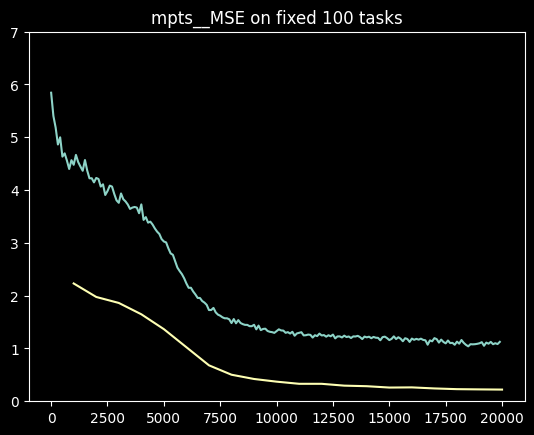

In [114]:
plt.plot(np.linspace(1, num_epochs+1, len(maml.meta_losses)+1)[:len(maml.meta_losses)], maml.meta_losses)
plt.plot(np.linspace(1, num_epochs+1, len(maml.test_score_all)+1)[:len(maml.test_score_all)]+maml.test_every, maml.test_score_all)
plt.title(sampling_strategy+"__MSE on fixed 100 tasks")
plt.ylim((0, 7))
plt.show()